<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU_LSTM/GRU_LSTM_Al.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

fatal: destination path 'feeder_repo' already exists and is not an empty directory.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data_reader.py  __pycache__  security_plotter.py
data	       LICENSE	       README.md    wandb


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Mon Jul 19 15:38:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Al'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU_LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 8.1MB/s 
     |████████████████████████████████| 174kB 38.3MB/s 
     |████████████████████████████████| 102kB 9.7MB/s 
     |████████████████████████████████| 143kB 38.6MB/s 
     |████████████████████████████████| 143kB 33.5MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(GRU(units=64, activation=config.activation, return_sequences=True, input_shape=(window_len, 1)))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(LSTM(units=64, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 3
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: ewraetva
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU_LSTM/sweeps/ewraetva


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: jcirtuab with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/200
16/16 [==============================] - 28s 104ms/step - loss: 0.0970 - mean_squared_error: 0.0970 - mean_absolute_error: 0.2452 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0664
Epoch 2/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0740 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0889
Epoch 3/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0515 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0653
Epoch 4/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0418 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0602
Epoch 5/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0029 - mean_square

epoch,163
loss,0.00098
mean_squared_error,0.00098
mean_absolute_error,0.02434
val_loss,0.00208
val_mean_squared_error,0.00208
val_mean_absolute_error,0.03175
_runtime,76
_timestamp,1626703928
_step,163
best_val_loss,0.00203


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: d6619k45 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 15s 250ms/step - loss: 0.0908 - mean_squared_error: 0.0908 - mean_absolute_error: 0.2008 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1121
Epoch 2/200
16/16 [==============================] - 3s 181ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0727 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0622
Epoch 3/200
16/16 [==============================] - 3s 169ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0500 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0865
Epoch 4/200
16/16 [==============================] - 3s 171ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0476 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0724
Epoch 5/200
16/16 [==============================] - 3s 182ms/step - loss: 0.0041 - mean_sq

epoch,132
loss,0.00092
mean_squared_error,0.00092
mean_absolute_error,0.02352
val_loss,0.0024
val_mean_squared_error,0.0024
val_mean_absolute_error,0.0358
_runtime,403
_timestamp,1626704375
_step,132
best_val_loss,0.00205


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▅▅▄▃▄▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁
val_mean_squared_error,██▅▅▄▃▄▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁
val_mean_absolute_error,▆█▅▄▃▃▃▄▂▂▃▃▂▂▂▂▂▁▂▁▁▃▁▃▂▂▁▁▁▁▂▁▂▂▁▃▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xj77ut3r with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 12s 223ms/step - loss: 0.0979 - mean_squared_error: 0.0979 - mean_absolute_error: 0.2557 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0615
Epoch 2/50
31/31 [==============================] - 6s 188ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0706 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0907
Epoch 3/50
31/31 [==============================] - 5s 164ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0683 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0667
Epoch 4/50
31/31 [==============================] - 5s 174ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0621 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0913
Epoch 5/50
31/31 [==============================] - 6s 180ms/step - loss: 0.0064 - mean_squared

epoch,26
loss,0.00213
mean_squared_error,0.00213
mean_absolute_error,0.03519
val_loss,0.0025
val_mean_squared_error,0.0025
val_mean_absolute_error,0.03502
_runtime,158
_timestamp,1626704542
_step,26
best_val_loss,0.00238


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▅▃▆▄█▇▂▂▁▂▂▂▁▅▂▁▁▂▁▁▁▂▃▁▁▁
val_mean_squared_error,▄▅▃▆▄█▇▂▂▁▂▂▂▁▅▂▁▁▂▁▁▁▂▃▁▁▁
val_mean_absolute_error,▃▆▄▆▅██▂▂▁▄▃▂▁▅▂▁▂▂▁▁▂▃▃▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: x4y9v1zt with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 12s 225ms/step - loss: 0.7657 - mean_squared_error: 0.7657 - mean_absolute_error: 0.4091 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0521
Epoch 2/100
31/31 [==============================] - 6s 188ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0427 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0472
Epoch 3/100
31/31 [==============================] - 6s 187ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0557 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0469
Epoch 4/100
31/31 [==============================] - 6s 182ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0500 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0454
Epoch 5/100
31/31 [==============================] - 6s 179ms/step - loss: 0.0024 - mean_sq

epoch,55
loss,0.00116
mean_squared_error,0.00116
mean_absolute_error,0.02626
val_loss,0.00203
val_mean_squared_error,0.00203
val_mean_absolute_error,0.0319
_runtime,329
_timestamp,1626704930
_step,55
best_val_loss,0.00199


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▄▃▂▅▃▂▅▂▂▁▂▁▂▃▁▁▁▂▁▁▁▁▃▁▁▁▁▄▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▄▃▂▅▃▂▅▂▂▁▂▁▂▃▁▁▁▂▁▁▁▁▃▁▁▁▁▄▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▅▅▇▃▃▃▇▅▂█▂▃▁▁▁▃▅▁▂▁▃▂▁▁▁▅▁▁▁▁▅▁▁▁▁▁▂▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: k14ehnzm with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 8s 246ms/step - loss: 0.1841 - mean_squared_error: 0.1841 - mean_absolute_error: 0.3430 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0777
Epoch 2/50
16/16 [==============================] - 3s 182ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0657 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0534
Epoch 3/50
16/16 [==============================] - 3s 182ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0464 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0530
Epoch 4/50
16/16 [==============================] - 3s 181ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0374 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0484
Epoch 5/50
16/16 [==============================] - 3s 167ms/step - loss: 0.0022 - mean_squared_

epoch,49
loss,0.00108
mean_squared_error,0.00108
mean_absolute_error,0.02539
val_loss,0.00218
val_mean_squared_error,0.00218
val_mean_absolute_error,0.03198
_runtime,210
_timestamp,1626705149
_step,49
best_val_loss,0.00208


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▃▃▃▄▂▂▂▂▃▂▂▂▂▃▂▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: w9s632zh with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 9s 265ms/step - loss: 0.1722 - mean_squared_error: 0.1722 - mean_absolute_error: 0.3466 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0998
Epoch 2/50
16/16 [==============================] - 3s 177ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0688 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0699
Epoch 3/50
16/16 [==============================] - 3s 169ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0555 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0595
Epoch 4/50
16/16 [==============================] - 3s 190ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0538 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0623
Epoch 5/50
16/16 [==============================] - 3s 186ms/step - loss: 0.0050 - mean_squared_

epoch,49
loss,0.00206
mean_squared_error,0.00206
mean_absolute_error,0.03566
val_loss,0.00621
val_mean_squared_error,0.00621
val_mean_absolute_error,0.04968
_runtime,160
_timestamp,1626705317
_step,49
best_val_loss,0.00471


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▄▅▄▄▄▄▃▃▄▃▃▄▂▃▂▂▂▂▂▂▂▂▃▂▂▂▂▁▃▁▁▂▁▁▁▂
val_mean_squared_error,█▅▅▅▄▅▄▄▄▄▃▃▄▃▃▄▂▃▂▂▂▂▂▂▂▂▃▂▂▂▂▁▃▁▁▂▁▁▁▂
val_mean_absolute_error,█▄▃▃▃▅▃▂▄▄▃▂▄▂▂▅▃▂▂▂▂▃▃▁▂▁▄▁▂▃▂▁▅▁▁▁▁▂▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3ahxmkvv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 9s 269ms/step - loss: 0.0834 - mean_squared_error: 0.0834 - mean_absolute_error: 0.2252 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1302
Epoch 2/100
16/16 [==============================] - 3s 197ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0792 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0629
Epoch 3/100
16/16 [==============================] - 3s 183ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0483 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0592
Epoch 4/100
16/16 [==============================] - 3s 174ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0446 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0592
Epoch 5/100
16/16 [==============================] - 3s 182ms/step - loss: 0.0033 - mean_squ

epoch,99
loss,0.00124
mean_squared_error,0.00124
mean_absolute_error,0.02688
val_loss,0.00251
val_mean_squared_error,0.00251
val_mean_absolute_error,0.03413
_runtime,315
_timestamp,1626705640
_step,99
best_val_loss,0.00234


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xcn5hqso with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 8s 375ms/step - loss: 0.0921 - mean_squared_error: 0.0921 - mean_absolute_error: 0.2293 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1415
Epoch 2/50
8/8 [==============================] - 2s 208ms/step - loss: 0.0181 - mean_squared_error: 0.0181 - mean_absolute_error: 0.1033 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0570
Epoch 3/50
8/8 [==============================] - 2s 199ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0528 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0889
Epoch 4/50
8/8 [==============================] - 2s 191ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0779 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0602
Epoch 5/50
8/8 [==============================] - 2s 202ms/step - loss: 0.0030 - mean_squared_error: 0.0

epoch,49
loss,0.00169
mean_squared_error,0.00169
mean_absolute_error,0.03158
val_loss,0.00406
val_mean_squared_error,0.00406
val_mean_absolute_error,0.04364
_runtime,90
_timestamp,1626705754
_step,49
best_val_loss,0.00319


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▂▂▃▁▃▁▂▁▂▂▁▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_loss,█▃▅▂▄▄▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,█▃▅▂▄▄▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▂▄▃▅▅▃▂▂▂▃▂▃▃▃▂▂▂▂▂▃▂▁▂▂▂▁▁▁▂▁▁▂▂▂▂▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: zqc04iv7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 7s 98ms/step - loss: 0.0756 - mean_squared_error: 0.0756 - mean_absolute_error: 0.2158 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0961
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0647 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0763
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0532 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0649
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0455 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0710
Epoch 5/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0031 - mean_squared_

epoch,99
loss,0.00134
mean_squared_error,0.00134
mean_absolute_error,0.0286
val_loss,0.00328
val_mean_squared_error,0.00328
val_mean_absolute_error,0.03781
_runtime,37
_timestamp,1626705800
_step,99
best_val_loss,0.00328


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▄▃▃▃▃▃▃▃▃▄▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ar51q8s0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 6s 55ms/step - loss: 0.1084 - mean_squared_error: 0.1084 - mean_absolute_error: 0.2543 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0720
Epoch 2/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0713 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0656
Epoch 3/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0484 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0657
Epoch 4/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0467 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0641
Epoch 5/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0034 - mean_squared_error

epoch,49
loss,0.00155
mean_squared_error,0.00155
mean_absolute_error,0.0302
val_loss,0.00374
val_mean_squared_error,0.00374
val_mean_absolute_error,0.03976
_runtime,33
_timestamp,1626705842
_step,49
best_val_loss,0.00374


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▆▅▅▅▅▄▅▅▄▅▄▄▄▃▅▃▄▄▃▅▃▂▃▃▃▃▂▂▂▂▂▁▂▂▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: vfhe2vw4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 6s 53ms/step - loss: 0.0473 - mean_squared_error: 0.0473 - mean_absolute_error: 0.1583 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0811
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0449 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0556
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0381 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0579
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0392 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0570
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0023 - mean_squared_

epoch,99
loss,0.00086
mean_squared_error,0.00086
mean_absolute_error,0.02261
val_loss,0.00202
val_mean_squared_error,0.00202
val_mean_absolute_error,0.03111
_runtime,55
_timestamp,1626705906
_step,99
best_val_loss,0.00196


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jfe1nt8d with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 9s 261ms/step - loss: 0.1821 - mean_squared_error: 0.1821 - mean_absolute_error: 0.3659 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.0956
Epoch 2/100
16/16 [==============================] - 3s 188ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.1116 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0814
Epoch 3/100
16/16 [==============================] - 3s 194ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0873 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0829
Epoch 4/100
16/16 [==============================] - 3s 187ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0622 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0712
Epoch 5/100
16/16 [==============================] - 3s 182ms/step - loss: 0.0046 - mean_squ

epoch,99
loss,0.00173
mean_squared_error,0.00173
mean_absolute_error,0.03156
val_loss,0.00298
val_mean_squared_error,0.00298
val_mean_absolute_error,0.03574
_runtime,317
_timestamp,1626706268
_step,99
best_val_loss,0.00292


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▄▄▄▄▃▃▃▃▃▃▂▂▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: p0ghpjrb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 6s 186ms/step - loss: 0.0732 - mean_squared_error: 0.0732 - mean_absolute_error: 0.2013 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0712
Epoch 2/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0469 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0613
Epoch 3/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0432 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0886
Epoch 4/200
8/8 [==============================] - 0s 22ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0741 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0515
Epoch 5/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0026 - mean_squared_error: 0.

epoch,103
loss,0.00143
mean_squared_error,0.00143
mean_absolute_error,0.02988
val_loss,0.00248
val_mean_squared_error,0.00248
val_mean_absolute_error,0.03673
_runtime,31
_timestamp,1626706323
_step,103
best_val_loss,0.00197


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▃▃▂▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▃▃▃▃▄▂▂▂▄▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,▅█▃▃▃▃▄▂▂▂▄▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,▆█▃▃▃▃▄▃▂▃▅▂▂▂▂▃▁▁▂▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▂▁▂▁▁▂
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: bdp0nqba with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 6s 180ms/step - loss: 0.0788 - mean_squared_error: 0.0788 - mean_absolute_error: 0.2155 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0786
Epoch 2/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0572 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0836
Epoch 3/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0525 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0667
Epoch 4/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0517 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0654
Epoch 5/200
8/8 [==============================] - 0s 15ms/step - loss: 0.0054 - mean_squared_error: 0.

epoch,199
loss,0.00138
mean_squared_error,0.00138
mean_absolute_error,0.0282
val_loss,0.00222
val_mean_squared_error,0.00222
val_mean_absolute_error,0.03313
_runtime,44
_timestamp,1626706378
_step,199
best_val_loss,0.00218


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▅▄▄▄▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▂▂▁▂
mean_squared_error,█▇▆▅▄▄▄▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▂▂▁▂
mean_absolute_error,█▇▆▅▄▄▄▄▃▄▃▃▄▃▃▃▃▂▂▂▂▃▃▂▂▂▂▂▁▂▂▂▁▁▂▂▂▂▁▂
val_loss,█▆▅▆▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,█▆▅▆▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▆▄▅▅▃▃▃▄▂▂▂▂▂▂▃▂▃▃▁▁▁▁▁▂▂▁▁▁▁▁▃▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: d5klozth with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 12s 232ms/step - loss: 0.3169 - mean_squared_error: 0.3169 - mean_absolute_error: 0.3416 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0528
Epoch 2/100
31/31 [==============================] - 6s 181ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0452 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0525
Epoch 3/100
31/31 [==============================] - 6s 188ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0402 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0461
Epoch 4/100
31/31 [==============================] - 6s 181ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0378 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0448
Epoch 5/100
31/31 [==============================] - 6s 181ms/step - loss: 0.0022 - mean_sq

epoch,48
loss,0.00087
mean_squared_error,0.00087
mean_absolute_error,0.02278
val_loss,0.00214
val_mean_squared_error,0.00214
val_mean_absolute_error,0.03215
_runtime,301
_timestamp,1626706698
_step,48
best_val_loss,0.00209


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁
val_mean_squared_error,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁
val_mean_absolute_error,██▆▅▅▅▃▃▃▄▃▂▃▄▂▁▂▂▂▂▂▂▁▁▂▂▂▁▂▁▁▁▃▁▁▂▃▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 8dxjlqsh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 6s 256ms/step - loss: 0.1645 - mean_squared_error: 0.1645 - mean_absolute_error: 0.3457 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.0931
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - mean_absolute_error: 0.1068 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1747
Epoch 3/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - mean_absolute_error: 0.1110 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0695
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0691 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0662
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0069 - mean_squared_error: 0.0069 

epoch,49
loss,0.00217
mean_squared_error,0.00217
mean_absolute_error,0.03632
val_loss,0.00619
val_mean_squared_error,0.00619
val_mean_absolute_error,0.0546
_runtime,20
_timestamp,1626706729
_step,49
best_val_loss,0.00617


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃█▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: q1za1c16 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 6s 199ms/step - loss: 0.1714 - mean_squared_error: 0.1714 - mean_absolute_error: 0.3529 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0862
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0954 - val_loss: 0.0329 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1718
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - mean_absolute_error: 0.1105 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0710
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0664 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0660
Epoch 5/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0071 - mean_squared_error: 0.0071 

epoch,49
loss,0.00231
mean_squared_error,0.00231
mean_absolute_error,0.03779
val_loss,0.00642
val_mean_squared_error,0.00642
val_mean_absolute_error,0.05476
_runtime,21
_timestamp,1626706760
_step,49
best_val_loss,0.00642


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃█▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 1kr5myzr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 7s 53ms/step - loss: 0.0578 - mean_squared_error: 0.0578 - mean_absolute_error: 0.1515 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0677
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0583 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0573
Epoch 3/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0522 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0630
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0443 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0648
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0032 - mean_squared_

epoch,64
loss,0.00116
mean_squared_error,0.00116
mean_absolute_error,0.02612
val_loss,0.00198
val_mean_squared_error,0.00198
val_mean_absolute_error,0.0308
_runtime,40
_timestamp,1626706820
_step,64
best_val_loss,0.00197


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▆▄▄▃▂▄▄▂▃▂▂▁▁▂▁▂▂▁▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▆▄▄▃▂▄▄▂▃▂▂▁▁▂▁▂▂▁▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▇▅█▅▃▆▆▂▆▂▂▂▂▂▂▂▃▂▃▂▃▃▂▁▁▁▁▁▃▁▁▁▁▂▂▂▂▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0f0ro5t2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 11s 228ms/step - loss: 0.0601 - mean_squared_error: 0.0601 - mean_absolute_error: 0.1623 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0749
Epoch 2/200
31/31 [==============================] - 6s 182ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0437 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0550
Epoch 3/200
31/31 [==============================] - 6s 182ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0396 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0524
Epoch 4/200
31/31 [==============================] - 6s 193ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0386 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0501
Epoch 5/200
31/31 [==============================] - 6s 206ms/step - loss: 0.0022 - mean_sq

epoch,84
loss,0.00096
mean_squared_error,0.00096
mean_absolute_error,0.02347
val_loss,0.00245
val_mean_squared_error,0.00245
val_mean_absolute_error,0.03684
_runtime,522
_timestamp,1626707354
_step,84
best_val_loss,0.00201


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 05wylkat with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 13s 232ms/step - loss: 0.1801 - mean_squared_error: 0.1801 - mean_absolute_error: 0.2634 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0911
Epoch 2/200
31/31 [==============================] - 6s 193ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0532 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0556
Epoch 3/200
31/31 [==============================] - 6s 196ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0496 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0471
Epoch 4/200
31/31 [==============================] - 6s 196ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0377 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0594
Epoch 5/200
31/31 [==============================] - 6s 187ms/step - loss: 0.0034 - mean_sq

epoch,40
loss,0.00152
mean_squared_error,0.00152
mean_absolute_error,0.0307
val_loss,0.00215
val_mean_squared_error,0.00215
val_mean_absolute_error,0.03195
_runtime,262
_timestamp,1626707674
_step,40
best_val_loss,0.00211


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▄▂▂▂▂▂▂▂▁▁▁▂▂▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▄▂▂▂▂▂▂▂▁▁▁▂▂▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▄▆▃▂▃▂▂▃▂▁▁▂▃▂▁▂▂▁▁▂▂▁▁▁▁▃▁▁▁▂▁▁▁▂▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: 9vy63og9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 7s 359ms/step - loss: 0.2272 - mean_squared_error: 0.2272 - mean_absolute_error: 0.4149 - val_loss: 0.0681 - val_mean_squared_error: 0.0681 - val_mean_absolute_error: 0.2102
Epoch 2/200
8/8 [==============================] - 2s 209ms/step - loss: 0.0582 - mean_squared_error: 0.0582 - mean_absolute_error: 0.1902 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0965
Epoch 3/200
8/8 [==============================] - 2s 190ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0727 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0892
Epoch 4/200
8/8 [==============================] - 1s 172ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0694 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0753
Epoch 5/200
8/8 [==============================] - 1s 170ms/step - loss: 0.0095 - mean_squared_error

epoch,199
loss,0.00189
mean_squared_error,0.00189
mean_absolute_error,0.03362
val_loss,0.00339
val_mean_squared_error,0.00339
val_mean_absolute_error,0.03728
_runtime,339
_timestamp,1626708032
_step,199
best_val_loss,0.00331


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▆▄▅▄▄▃▃▃▃▃▃▂▃▃▃▂▂▂▃▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁
val_mean_squared_error,█▆▅▆▄▅▄▄▃▃▃▃▃▃▂▃▃▃▂▂▂▃▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▆▄▆▃▃▃▄▃▃▃▃▃▂▃▂▂▂▃▄▃▂▂▂▂▂▁▁▁▂▁▃▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: smil5a41 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 7s 104ms/step - loss: 0.0517 - mean_squared_error: 0.0517 - mean_absolute_error: 0.1493 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0887
Epoch 2/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0640 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0901
Epoch 3/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0599 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0599
Epoch 4/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0393 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0806
Epoch 5/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0049 - mean_squared

epoch,67
loss,0.0011
mean_squared_error,0.0011
mean_absolute_error,0.02551
val_loss,0.00248
val_mean_squared_error,0.00248
val_mean_absolute_error,0.03539
_runtime,36
_timestamp,1626708132
_step,67
best_val_loss,0.00206


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▂▃▂▂▃▂▂▂▂▂▁▁▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁
val_loss,▇▇█▃▃▃▂▂▂▂▂▂▂▂▁▁▂▂▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇▇█▃▃▃▂▂▂▂▂▂▂▂▁▁▂▂▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▃▃▄▃▂▂▂▂▃▂▂▁▁▃▃▁▂▅▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▂▂▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: zrq0uhaw with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 7s 376ms/step - loss: 0.2110 - mean_squared_error: 0.2110 - mean_absolute_error: 0.4012 - val_loss: 0.0758 - val_mean_squared_error: 0.0758 - val_mean_absolute_error: 0.2250
Epoch 2/50
8/8 [==============================] - 2s 208ms/step - loss: 0.0693 - mean_squared_error: 0.0693 - mean_absolute_error: 0.2119 - val_loss: 0.0504 - val_mean_squared_error: 0.0504 - val_mean_absolute_error: 0.2127
Epoch 3/50
8/8 [==============================] - 2s 189ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - mean_absolute_error: 0.1345 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.0867
Epoch 4/50
8/8 [==============================] - 2s 192ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0995 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0744
Epoch 5/50
8/8 [==============================] - 2s 199ms/step - loss: 0.0048 - mean_squared_error: 0.0

epoch,49
loss,0.00215
mean_squared_error,0.00215
mean_absolute_error,0.03642
val_loss,0.00525
val_mean_squared_error,0.00525
val_mean_absolute_error,0.04561
_runtime,95
_timestamp,1626708239
_step,49
best_val_loss,0.00524


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▃▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂▁▁▁▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7dqm5uvo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 9s 271ms/step - loss: 0.1201 - mean_squared_error: 0.1201 - mean_absolute_error: 0.2899 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0661
Epoch 2/200
16/16 [==============================] - 3s 197ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0851 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0875
Epoch 3/200
16/16 [==============================] - 3s 205ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0940 - val_loss: 0.0390 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1696
Epoch 4/200
16/16 [==============================] - 3s 191ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - mean_absolute_error: 0.1032 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0801
Epoch 5/200
16/16 [==============================] - 3s 198ms/step - loss: 0.0077 - mean_squ

epoch,28
loss,0.00266
mean_squared_error,0.00266
mean_absolute_error,0.04003
val_loss,0.00412
val_mean_squared_error,0.00412
val_mean_absolute_error,0.05264
_runtime,105
_timestamp,1626708357
_step,28
best_val_loss,0.00279


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁
val_loss,▂▄█▂▂▂▂▃▂▂▁▂▂▃▂▂▁▁▁▁▂▁▁▂▁▃▁▁▁
val_mean_squared_error,▂▄█▂▂▂▂▃▂▂▁▂▂▃▂▂▁▁▁▁▂▁▁▂▁▃▁▁▁
val_mean_absolute_error,▃▄█▃▄▃▂▅▂▂▂▃▂▄▃▂▁▁▁▁▃▁▂▂▂▄▁▂▂
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: lz6v6460 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 6s 55ms/step - loss: 0.0603 - mean_squared_error: 0.0603 - mean_absolute_error: 0.1605 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0892
Epoch 2/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0520 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0660
Epoch 3/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0486 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0577
Epoch 4/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0496 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0706
Epoch 5/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0037 - mean_squared_

epoch,99
loss,0.00102
mean_squared_error,0.00102
mean_absolute_error,0.02471
val_loss,0.00199
val_mean_squared_error,0.00199
val_mean_absolute_error,0.03106
_runtime,60
_timestamp,1626708476
_step,99
best_val_loss,0.00198


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▃▂▂▃▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▃▃▃▂▂▃▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▅▃▃▃▂▂▄▂▂▂▂▁▁▁▁▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t37ox6q9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 10s 283ms/step - loss: 0.0537 - mean_squared_error: 0.0537 - mean_absolute_error: 0.1634 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0856
Epoch 2/50
16/16 [==============================] - 3s 195ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0609 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0564
Epoch 3/50
16/16 [==============================] - 3s 198ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0501 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0525
Epoch 4/50
16/16 [==============================] - 3s 184ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0531 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0551
Epoch 5/50
16/16 [==============================] - 3s 196ms/step - loss: 0.0040 - mean_squared

epoch,49
loss,0.00172
mean_squared_error,0.00172
mean_absolute_error,0.03168
val_loss,0.00406
val_mean_squared_error,0.00406
val_mean_absolute_error,0.0467
_runtime,179
_timestamp,1626708691
_step,49
best_val_loss,0.00351


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▅▅▄▃▃▄▃▃▃▃▂▂▂▅▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▅▅▄▃▃▄▃▃▃▃▂▂▂▅▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▄▃▂▃▃▃▂▂▂▆▂▃▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▂▂▁▂▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: wapidiid with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 12s 243ms/step - loss: 0.0669 - mean_squared_error: 0.0669 - mean_absolute_error: 0.1622 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0809
Epoch 2/50
31/31 [==============================] - 6s 205ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0757 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0616
Epoch 3/50
31/31 [==============================] - 6s 201ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0543 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0549
Epoch 4/50
31/31 [==============================] - 6s 206ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0564 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0542
Epoch 5/50
31/31 [==============================] - 6s 202ms/step - loss: 0.0049 - mean_squared

epoch,49
loss,0.0013
mean_squared_error,0.0013
mean_absolute_error,0.02735
val_loss,0.0025
val_mean_squared_error,0.0025
val_mean_absolute_error,0.03651
_runtime,319
_timestamp,1626709025
_step,49
best_val_loss,0.00195


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▄▂▂▂▂▂▂▁▂▁▁▁▂▁▃▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▄▂▂▂▂▂▂▁▂▁▁▁▂▁▃▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▆▃▃▃▂▄▃▁▄▁▁▂▂▁▅▂▂▂▃▂▃▁▃▁▁▁▂▂▁▁▁▁▂▂▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: qjdbs50p with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [9]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'learning_rate': 0.001,
    'dropout': 0.2,
    'optimizer': 'rmsprop',
    'activation': 'tanh'
}

In [10]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(GRU(units=64, activation=best_config['activation'], return_sequences=True, input_shape=(window_len, 1)))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(LSTM(units=64, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 3
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  45953


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 64)            12864     
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 45,953
Trainable params: 45,953
Non-trainable params: 0
_________________________________________________________________


In [12]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
39/39 [==============================] - 22s 7ms/step - loss: 0.0289
Epoch 2/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0046
Epoch 3/100
39/39 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 4/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 5/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 6/100
39/39 [==============================] - 0s 8ms/step - loss: 0.0031
Epoch 7/100
39/39 [==============================] - 0s 11ms/step - loss: 0.0024
Epoch 8/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0025
Epoch 9/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0022
Epoch 10/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 11/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0026
Epoch 12/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 13/100
39/39 [===============

In [13]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

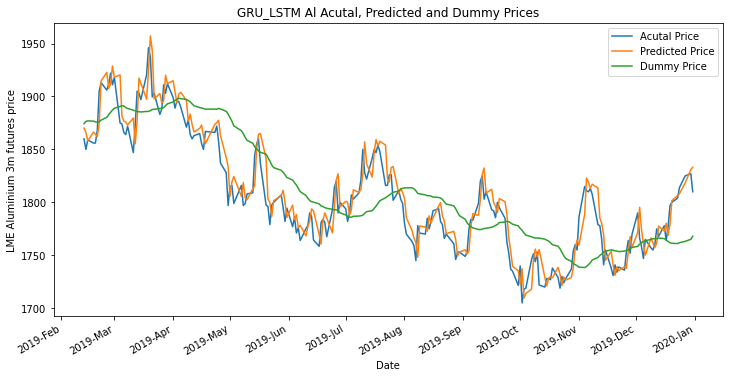

In [14]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

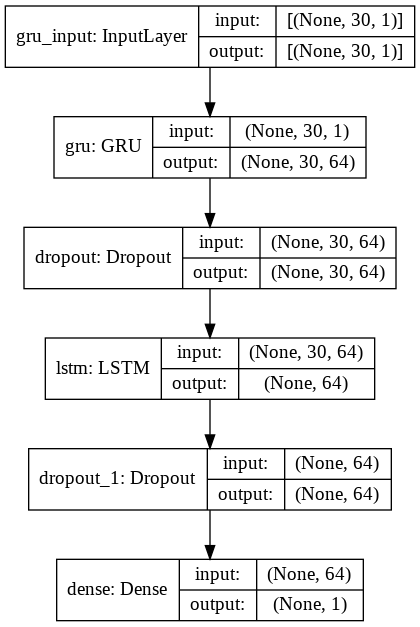

In [15]:
plot_model(model, show_shapes=True, expand_nested=True)

In [16]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.004271460093059409
RMSE:  0.0653564082019461
MAE:  0.05228422306781763
Dummy MSE:  0.019334874061718535
Dummy RMSE:  0.13904989774076978
Dummy MAE:  0.11616489589341868


In [17]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_LSTM_Al/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_LSTM_Al/assets
